# Creating the env

In [2]:
import os
import sys
import subprocess

# Define environment name
venv_dir = "gut_microbiome_env"

if not os.path.exists(venv_dir):
    print(f"Creating virtual environment '{venv_dir}'...")
    subprocess.run([sys.executable, "-m", "venv", venv_dir])
    print("Virtual environment created.")


packages = [
    "numpy", "pandas", "matplotlib", "seaborn", "scikit-learn",
    "umap-learn", "h5py", "scikit-bio", "biom-format", "scipy"
]

In [3]:
!source gut_microbiome_env/bin/activate

In [ ]:
import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.decomposition import PCA
import seaborn as sns

In [5]:
sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


NameError: name 'sns' is not defined

# Load Data

In [15]:
# Load data
data_dir = "data"
ab_path = os.path.join(data_dir, "MetaCardis2020_relative_abundance.csv")
meta_path = os.path.join(data_dir, "MetaCardis2020_sample_metadata.csv")
taxa_meta_path = os.path.join(data_dir, "MetaCardis2020_taxa_metadata.csv")

RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")
os.makedirs(FIGS, exist_ok=True); os.makedirs(TABLES, exist_ok=True)


In [16]:
ab_raw = pd.read_csv(ab_path, index_col=0)
meta = pd.read_csv(meta_path, index_col=0)
taxa_meta = pd.read_csv(taxa_meta_path, index_col=0)

print("ab_raw.shape (rows x cols):", ab_raw.shape)
print("meta.shape:", meta.shape)
print("taxa_meta.shape:", taxa_meta.shape)
display(ab_raw.head().T)   
display(meta.head())
display(taxa_meta.head())

ab_raw.shape (rows x cols): (697, 1831)
meta.shape: (1831, 25)
taxa_meta.shape: (697, 7)


taxa,Bacteroides uniformis,Phocaeicola dorei,Alistipes finegoldii,Phocaeicola vulgatus,Eubacterium sp. CAG:180
M0x10MCx1134,18.68909,10.88477,8.14016,7.69579,5.24825
M0x10MCx1135,0.47634,0.12509,0.11658,0.06780,5.09389
M0x10MCx1138,1.69175,19.99088,0.31639,1.37651,0.00000
M0x10MCx1140,8.54740,8.29615,0.00000,2.42549,0.00000
M0x10MCx1143,11.01829,28.54958,0.00000,0.00000,0.00000
...,...,...,...,...,...
M0x30MCx3384,1.09316,0.14840,0.00000,1.80244,2.05756
M0x30MCx3412,38.16991,4.62311,0.17234,5.02784,0.00000
M0x30MCx3414,0.90933,1.27721,0.73518,1.56852,3.94000
M0x30MCx3422,7.93352,1.23356,0.91919,3.94948,0.00000


,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age_category,gender,country,non_westernized,...,BMI,treatment,location,disease_subtype,triglycerides,hba1c,smoke,bristol_score,hsCRP,LDL
M0x10MCx1134,MetaCardis_2020_a,M0x10MCx1134,stool,no,IGT,IGT;MS,adult,female,FRA,no,...,44.365888,antihta;thiazidique;at2_inhib,Paris,NaN,97.940706,6.0,no,1.0,1.3,140.673726
M0x10MCx1135,MetaCardis_2020_a,M0x10MCx1135,stool,no,T2D,T2D,adult,male,FRA,no,...,27.719670,antidiab;su;metformin;dppiv;insulin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1138,MetaCardis_2020_a,M0x10MCx1138,stool,yes,T2D,T2D,adult,male,FRA,no,...,38.221055,antidiab;su;metformin,Paris,NaN,NaN,NaN,1.0,NaN,NaN,NaN
M0x10MCx1140,MetaCardis_2020_a,M0x10MCx1140,stool,NaN,control,MS,adult,female,FRA,no,...,36.283006,antihta;thiazidique;at2_inhib;ca2_cbl,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1143,MetaCardis_2020_a,M0x10MCx1143,stool,yes,T2D,T2D,senior,female,FRA,no,...,39.817729,antihta;antidiab;thiazidique;at2_inhib;metformin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN


,superkingdom,phylum,class,order,family,genus,species
Bacteroides uniformis,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides uniformis
Phocaeicola dorei,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei
Alistipes finegoldii,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii
Phocaeicola vulgatus,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
Eubacterium sp. CAG:180,Bacteria,Firmicutes,Clostridia,Eubacteriales,Eubacteriaceae,Eubacterium,Eubacterium sp. CAG:180


In [17]:
#transpose abundance and check alignment
ab = ab_raw.T.copy()   # rows = samples, cols = taxa
print("ab (samples x taxa) shape:", ab.shape)

print("First 5 sample IDs in abundance:", list(ab.index[:5]))
print("First 5 sample IDs in metadata:", list(meta.index[:5]))

# how many sample IDs overlap between abundance and metadata?
common = ab.index.intersection(meta.index)
print(f"Common sample IDs: {len(common)} / {ab.shape[0]} (abundance) and {meta.shape[0]} (metadata)")

ab (samples x taxa) shape: (1831, 697)
First 5 sample IDs in abundance: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
First 5 sample IDs in metadata: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
Common sample IDs: 1831 / 1831 (abundance) and 1831 (metadata)


In [18]:
# show up to 5 example mismatches (if any)
ab_only = list(sorted(set(ab.index) - set(meta.index)))[:5]
meta_only = list(sorted(set(meta.index) - set(ab.index)))[:5]
print("Example sample IDs present in abundance but NOT in metadata:", ab_only)
print("Example sample IDs present in metadata but NOT in abundance:", meta_only)

Example sample IDs present in abundance but NOT in metadata: []
Example sample IDs present in metadata but NOT in abundance: []


In [19]:
#Check duplicates and missingness

# Check for duplicate sample IDs
dup_ab = ab.index[ab.index.duplicated()]
dup_meta = meta.index[meta.index.duplicated()]
print("Duplicate samples in abundance:", len(dup_ab))
print("Duplicate samples in metadata:", len(dup_meta))

# Check for missing values in metadata
missing_counts = meta.isna().sum().sort_values(ascending=False)
print("\nTop 10 metadata columns with missing values:")
print(missing_counts.head(10))

Duplicate samples in abundance: 0
Duplicate samples in metadata: 0

Top 10 metadata columns with missing values:
disease_subtype            1822
hsCRP                      1002
bristol_score               997
hba1c                       992
LDL                         990
triglycerides               987
smoke                       528
BMI                         521
gender                      514
antibiotics_current_use     104
dtype: int64


In [20]:
# Look at unique values in the disease/study_condition columns
print("Unique values in 'study_condition':", meta['study_condition'].unique()[:10])
print("Unique values in 'disease':", meta['disease'].unique()[:10])

Unique values in 'study_condition': ['IGT' 'T2D' 'control' 'CAD' 'HF']
Unique values in 'disease': ['IGT;MS' 'T2D' 'MS' 'CAD' 'CAD;T2D' 'HF;T2D' 'healthy' 'IGT' 'MA'
 'HF;CAD']


In [21]:
# create unified Healthy vs Disease label
def map_health(row):
    cond = str(row['study_condition']).lower()
    dis = str(row['disease']).lower()
    if ('control' in cond) or ('healthy' in dis):
        return 'Healthy'
    else:
        return 'Disease'

meta['health_status'] = meta.apply(map_health, axis=1)

# Check how many samples in each class
print("Health status counts:")
print(meta['health_status'].value_counts(dropna=False))

# Drop samples with no label (if any)
meta = meta.dropna(subset=['health_status'])
ab = ab.loc[meta.index]
print("After removing unlabeled samples -> samples:", ab.shape[0])

Health status counts:
health_status
Disease    1189
Healthy     642
Name: count, dtype: int64
After removing unlabeled samples -> samples: 1831


In [22]:
# Clean antibiotics and treatment columns

if 'antibiotics_current_use' in meta.columns:
    meta['antibiotics_current_use'] = (
        meta['antibiotics_current_use']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )

    # Standardize values
    def clean_antibiotic(x):
        if pd.isna(x):
            return 'unknown'
        elif x.startswith('y'):
            return 'yes'
        elif x.startswith('n'):
            return 'no'
        else:
            return 'unknown'

    meta['antibiotic_use'] = meta['antibiotics_current_use'].apply(clean_antibiotic)
else:
    # If the column doesn't exist, create an empty one
    meta['antibiotic_use'] = 'unknown'

print("Antibiotic use value counts:")
print(meta['antibiotic_use'].value_counts(dropna=False))

# Clean treatment information (string normalization)
if 'treatment' in meta.columns:
    meta['treatment'] = (
        meta['treatment']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )
else:
    meta['treatment'] = np.nan


print("\nMost common treatments:")
print(meta['treatment'].value_counts().head(10))


Antibiotic use value counts:
antibiotic_use
no         944
yes        783
unknown    104
Name: count, dtype: int64

Most common treatments:
treatment
no                                                       539
ppi                                                       32
antidiab;metformin                                        25
antihta;ace_inhib                                         24
antilipid;antihta;beta_blockers;statin;antithombo;asa     24
antihta;beta_blockers                                     21
antilipid;statin                                          20
antidiab;metformin;dppiv                                  18
antihta;at2_inhib                                         17
antilipid;statin;asa                                      15
Name: count, dtype: int64


In [23]:
# How many samples in the dataset
n_samples = ab.shape[0]

# Count in how many samples each taxon appears (>0)
prevalence = (ab > 0).sum(axis=0)

n_samples
prevalence

taxa
Bacteroides uniformis             1756
Phocaeicola dorei                 1297
Alistipes finegoldii              1489
Phocaeicola vulgatus              1640
Eubacterium sp. CAG:180            688
                                  ... 
Mageeibacillus indolicus             1
Dialister micraerophilus             1
Tissierellia bacterium KA00581       1
Anaerococcus lactolyticus            1
Actinomyces naeslundii               1
Length: 697, dtype: int64

In [24]:
# Filter rare taxa (low prevalence)

# Choose a threshold (e.g. ≥5 % of samples)
min_samples = math.ceil(0.05 * n_samples)
keep_taxa = prevalence[prevalence >= min_samples].index
print(f"Keeping {len(keep_taxa)} taxa out of {ab.shape[1]} (≥5% prevalence)")

# Filter the abundance table
ab_filt = ab[keep_taxa].copy()
print("Filtered abundance shape:", ab_filt.shape)

# also make a 1% version to test sensitivity later
min_samples_1pct = math.ceil(0.01 * n_samples)
keep_taxa_1pct = prevalence[prevalence >= min_samples_1pct].index
ab_filt_1pct = ab[keep_taxa_1pct].copy()
print("1% version shape:", ab_filt_1pct.shape)


Keeping 228 taxa out of 697 (≥5% prevalence)
Filtered abundance shape: (1831, 228)
1% version shape: (1831, 362)


In [25]:
# Normalize filtered table to relative abundances (sum = 1 per sample)

# use 1% filtered version for main analysis
ab_rel = ab_filt_1pct.div(ab_filt_1pct.sum(axis=1), axis=0).fillna(0)

# every sample should now sum ≈ 1
sample_sums = ab_rel.sum(axis=1)
print("Relative-abundance sample sums (min–max):", sample_sums.min(), "-", sample_sums.max())

# if any sample sums = 0 → drop it 
zero_sum = sample_sums[sample_sums == 0].index
if len(zero_sum) > 0:
    print("Dropping", len(zero_sum), "zero-sum samples")
    ab_rel = ab_rel.drop(index=zero_sum)
    meta = meta.loc[ab_rel.index]

print("Normalized abundance shape:", ab_rel.shape)

# Save normalized version
ab_rel.to_csv(os.path.join(TABLES, "abundance_filtered1pct_relative.csv"))


Relative-abundance sample sums (min–max): 0.9999999999999984 - 1.0000000000000013
Normalized abundance shape: (1831, 362)


In [1]:
# Define diversity functions
def shannon(p):
    p = p[p > 0]
    return -(p * np.log(p)).sum()

def simpson(p):
    return 1 - (p**2).sum()

# Compute metrics for each sample
alpha = pd.DataFrame(index=ab_rel.index)
alpha['richness'] = (ab_rel > 0).sum(axis=1)
alpha['shannon'] = ab_rel.apply(shannon, axis=1)
alpha['simpson'] = ab_rel.apply(simpson, axis=1)

# Merge key metadata (for plotting & stratification)
alpha = alpha.join(meta[['health_status', 'antibiotic_use', 'treatment']])
alpha.head()

NameError: name 'pd' is not defined

/var/folders/mh/p8rsw7z90bv6kv8r8qnf4tnr0000gn/T/ipykernel_33473/2109340334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')


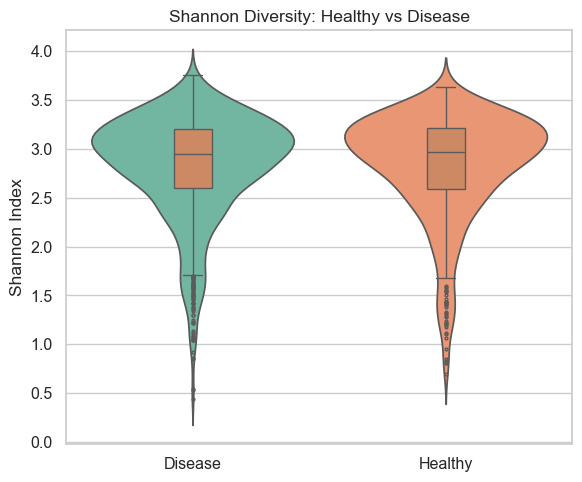

In [27]:
# Visualize Shannon diversity by health status
plt.figure(figsize=(6,5))
sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')
sns.boxplot(x='health_status', y='shannon', data=alpha, width=0.15, showcaps=True, boxprops={'zorder':2}, fliersize=2)
plt.title("Shannon Diversity: Healthy vs Disease")
plt.ylabel("Shannon Index")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_vs_disease.png"), dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# Mann–Whitney U test for diversity difference
healthy = alpha.loc[alpha['health_status'] == 'Healthy', 'shannon']
disease = alpha.loc[alpha['health_status'] == 'Disease', 'shannon']

u_stat, p_val = mannwhitneyu(healthy, disease, alternative='two-sided')
print(f"Mann–Whitney test (Shannon, Healthy vs Disease): p = {p_val:.3e}, U = {u_stat}")
print(f"Healthy mean = {healthy.mean():.3f}, Disease mean = {disease.mean():.3f}")


Mann–Whitney test (Shannon, Healthy vs Disease): p = 6.539e-01, U = 386510.0
Healthy mean = 2.824, Disease mean = 2.825


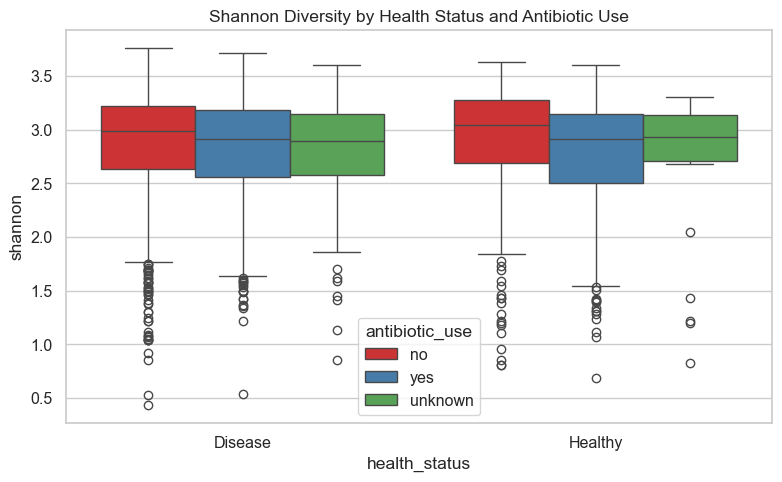

In [29]:
# Shannon diversity by health status & antibiotic use
plt.figure(figsize=(8,5))
sns.boxplot(x='health_status', y='shannon', hue='antibiotic_use', data=alpha, palette='Set1')
plt.title("Shannon Diversity by Health Status and Antibiotic Use")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


In [30]:
for abx in ['yes', 'no']:
    sub = alpha[alpha['antibiotic_use'] == abx]
    if len(sub['health_status'].unique()) == 2:
        h = sub.loc[sub['health_status'] == 'Healthy', 'shannon']
        d = sub.loc[sub['health_status'] == 'Disease', 'shannon']
        u, p = mannwhitneyu(h, d, alternative='two-sided')
        print(f"Antibiotic={abx}: p={p:.3e}, n_Healthy={len(h)}, n_Disease={len(d)}")


Antibiotic=yes: p=3.376e-01, n_Healthy=297, n_Disease=486
Antibiotic=no: p=8.942e-02, n_Healthy=319, n_Disease=625


In [31]:
# Does antibiotic use itself reduce Shannon diversity?
yes_abx = alpha.loc[alpha['antibiotic_use'] == 'yes', 'shannon']
no_abx = alpha.loc[alpha['antibiotic_use'] == 'no', 'shannon']

u_abx, p_abx = mannwhitneyu(yes_abx, no_abx, alternative='two-sided')
print(f"Antibiotic (yes vs no): p={p_abx:.3e}, mean yes={yes_abx.mean():.3f}, mean no={no_abx.mean():.3f}")


Antibiotic (yes vs no): p=1.161e-04, mean yes=2.799, mean no=2.855


In [32]:
alpha.to_csv(os.path.join(TABLES, "alpha_diversity.csv"))

## 1) CLR transform

In [33]:
# 1) CLR transform
# Settings
pseudocount = 1e-6
n_components = 30
top_loadings = 15

# Ensure ab_rel is a DataFrame with samples x taxa and rows sum ~1
print("ab_rel shape:", ab_rel.shape)
print("Row sums (min, max):", ab_rel.sum(axis=1).min(), ab_rel.sum(axis=1).max())

ab_rel shape: (1831, 362)
Row sums (min, max): 0.9999999999999984 1.0000000000000013


In [34]:
# Add pseudocount and renormalize
X = ab_rel.copy().astype(float)
X_pseudo = X + pseudocount

# Compute geometric mean per sample (for CLR)
gm = np.exp(np.log(X_pseudo).mean(axis=1))

# CLR: log(x) - log(gm)
clr = np.log(X_pseudo).subtract(np.log(gm), axis=0)

print("CLR shape:", clr.shape)
print("CLR per-sample mean (should be ~0):")
print(clr.mean(axis=1).head())

# Save CLR table
clr_path = os.path.join(TABLES, "abundance_clr_1pct_pseudocount{:.0e}.csv".format(pseudocount))
clr.to_csv(clr_path)
print("Saved CLR table to:", clr_path)

CLR shape: (1831, 362)
CLR per-sample mean (should be ~0):
M0x10MCx1134    5.177933e-14
M0x10MCx1135    6.400773e-14
M0x10MCx1138    7.291896e-14
M0x10MCx1140    7.274721e-14
M0x10MCx1143    7.141740e-14
dtype: float64
Saved CLR table to: data/results_EDA/tables/abundance_clr_1pct_pseudocount1e-06.csv


## PCA on CLR-transformed data

In [35]:
#PCA
pca = PCA(n_components=n_components, svd_solver='auto')
pca_res = pca.fit(clr.values)

# Build results dataframes
pcs = pd.DataFrame(pca_res.transform(clr.values),
                   index=clr.index,
                   columns=[f"PC{i+1}" for i in range(pca_res.n_components_)])
explained = pd.Series(pca_res.explained_variance_ratio_,
                      index=[f"PC{i+1}" for i in range(pca_res.n_components_)],
                      name="explained_variance_ratio")

loadings = pd.DataFrame(pca_res.components_.T,
                        index=clr.columns,
                        columns=[f"PC{i+1}" for i in range(pca_res.n_components_)])

# Merge PCs with metadata for plotting
pcs_meta = pcs.join(meta[['health_status', 'antibiotic_use', 'treatment']], how='left')

# Print variance explained
print("\nExplained variance ratio (first 10 PCs):")
print(explained.head(10).round(4))
print("Cumulative variance explained (first 3 PCs):", explained.iloc[:3].sum().round(4))


Explained variance ratio (first 10 PCs):
PC1     0.0862
PC2     0.0455
PC3     0.0333
PC4     0.0255
PC5     0.0207
PC6     0.0163
PC7     0.0157
PC8     0.0145
PC9     0.0133
PC10    0.0129
Name: explained_variance_ratio, dtype: float64
Cumulative variance explained (first 3 PCs): 0.1649


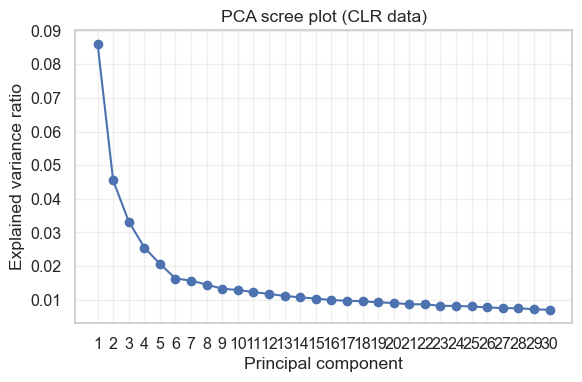

Saved scree plot to: data/results_EDA/figures/pca_scree_clr.png


In [36]:
# Scree plot

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained)+1), explained.values, marker='o')
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("PCA scree plot (CLR data)")
plt.xticks(np.arange(1, len(explained)+1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
scree_path = os.path.join(FIGS, "pca_scree_clr.png")
plt.savefig(scree_path, dpi=150)
plt.show()
print("Saved scree plot to:", scree_path)

# Beta Diversity

In [37]:
# PCoA via eigen-decomposition
def pcoa_from_distance(D, k=2):
    """
    Classical metric MDS (PCoA) from a precomputed distance matrix D.
    Returns coordinates (N x k) and explained variance ratios.
    """
    # Double-centering
    D2 = D ** 2
    n = D.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D2 @ J

    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep only positive eigenvalues
    pos = eigvals > 0
    eigvals_pos = eigvals[pos]
    eigvecs_pos = eigvecs[:, pos]

    # Coordinates
    coords = eigvecs_pos[:, :k] * np.sqrt(eigvals_pos[:k])

    # Variance explained (only positive eigvals make sense)
    var_exp = eigvals_pos / eigvals_pos.sum()
    var_ratio = var_exp[:k]
    return coords, var_ratio


In [38]:
## 1) BRAY–CURTIS distance + PCoA

# Compute Bray–Curtis distance on relative abundance (samples x taxa)
bc_dist = pdist(ab_rel.values, metric='braycurtis')
bc_DM = squareform(bc_dist)  # (N x N)

# PCoA coordinates
bc_coords, bc_var = pcoa_from_distance(bc_DM, k=2)

# Build a plotting frame with metadata
bc_df = pd.DataFrame(bc_coords, index=ab_rel.index, columns=['PCo1', 'PCo2'])
bc_df = bc_df.join(meta[['health_status', 'antibiotic_use', 'treatment']])

# Save distance matrix and coordinates
pd.DataFrame(bc_DM, index=ab_rel.index, columns=ab_rel.index)\
  .to_csv(os.path.join(TABLES, "beta_braycurtis_distance_matrix.csv"))
bc_df.to_csv(os.path.join(TABLES, "beta_braycurtis_pcoa_coords.csv"))

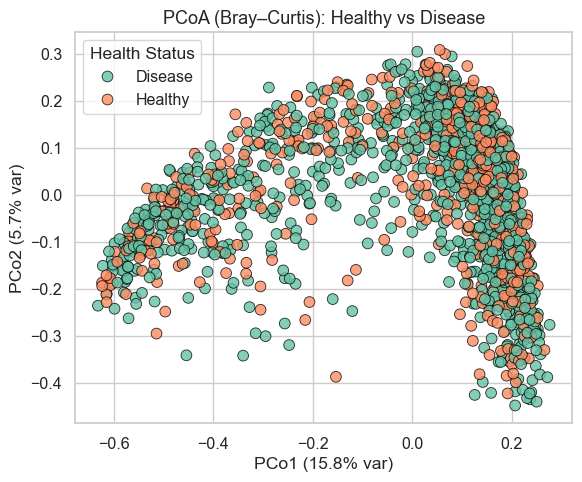

In [39]:
# PCoA plot colored by Health Status
plt.figure(figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): Healthy vs Disease", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Health Status", frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_healthstatus.png"), dpi=300)
plt.show()

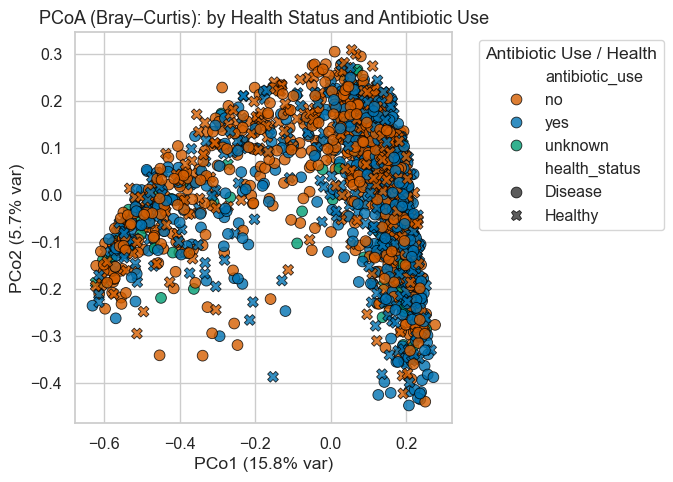

In [40]:
# Plot: PCoA colored by Antibiotic Use
plt.figure(figsize=(7,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00','yes':'#0072B2','unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): by Health Status and Antibiotic Use", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Antibiotic Use / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


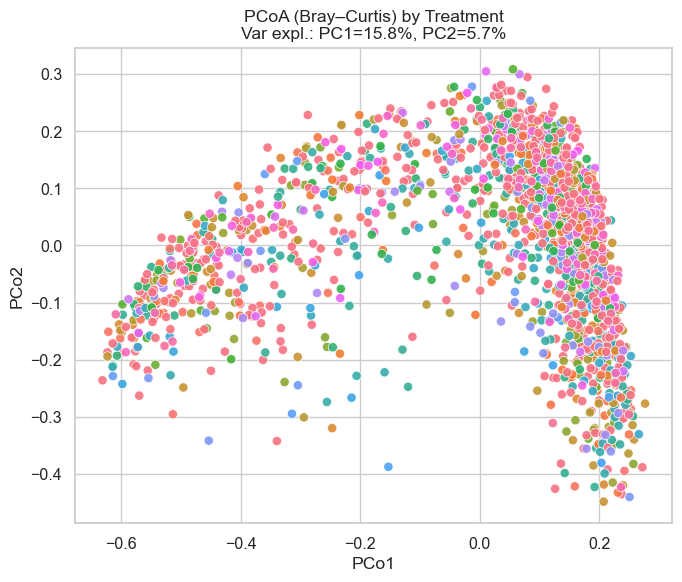

In [41]:
# PCoA colored by Treatment
if meta['treatment'].notna().sum() > 0 and meta['treatment'].nunique() > 1:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=bc_df, x='PCo1', y='PCo2',
        hue='treatment', s=45, edgecolor='white', alpha=0.9, legend=False
    )
    plt.title(f"PCoA (Bray–Curtis) by Treatment\nVar expl.: PC1={bc_var[0]:.1%}, PC2={bc_var[1]:.1%}")
    plt.xlabel("PCo1")
    plt.ylabel("PCo2")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_by_treatment.png"), dpi=300, bbox_inches='tight')
    plt.show()



In [42]:
# PERMANOVA on Bray–Curtis

dm = DistanceMatrix(bc_DM, ids=list(ab_rel.index))
# Health status
res_health = permanova(dm, bc_df['health_status'], permutations=999)
print("\nPERMANOVA (Bray–Curtis) ~ health_status")
print(res_health)
# Antibiotic use
res_abx = permanova(dm, bc_df['antibiotic_use'], permutations=999)
print("\nPERMANOVA (Bray–Curtis) ~ antibiotic_use")
print(res_abx)
# Save tables
with open(os.path.join(TABLES, "permanova_braycurtis.txt"), "w") as f:
    f.write("PERMANOVA (Bray–Curtis) ~ health_status\n")
    f.write(str(res_health) + "\n\n")
    f.write("PERMANOVA (Bray–Curtis) ~ antibiotic_use\n")
    f.write(str(res_abx) + "\n")



PERMANOVA (Bray–Curtis) ~ health_status
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  2
test statistic             4.094901
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA (Bray–Curtis) ~ antibiotic_use
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  3
test statistic             5.152043
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


# 2) CLR + PCA

In [43]:
# CLR transform: add a small pseudocount to avoid log(0)
def clr_transform(df, pseudo=1e-6):
    X = df.values + pseudo
    logX = np.log(X)
    gm = logX.mean(axis=1, keepdims=True)  # per-sample geometric mean in log space
    clr = logX - gm
    return pd.DataFrame(clr, index=df.index, columns=df.columns)

ab_clr = clr_transform(ab_rel, pseudo=1e-6)

# PCA on CLR data (captures Aitchison structure)
pca = PCA(n_components=2, random_state=2025)
clr_pcs = pca.fit_transform(ab_clr.values)
clr_df = pd.DataFrame(clr_pcs, index=ab_rel.index, columns=['PC1', 'PC2'])
clr_df = clr_df.join(meta[['health_status', 'antibiotic_use', 'treatment']])

# Save coordinates
clr_df.to_csv(os.path.join(TABLES, "beta_aitchison_clr_pca_coords.csv"))


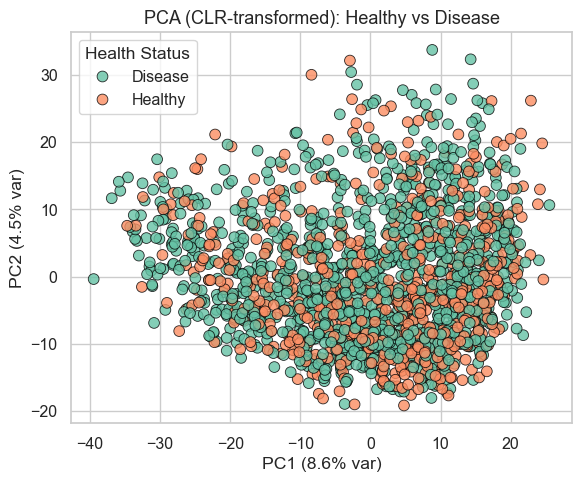

In [44]:
# Plot: PCA (CLR) colored by Health Status
plt.figure(figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=clr_df, x='PC1', y='PC2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): Healthy vs Disease", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Health Status")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pca_clr_healthstatus.png"), dpi=300)
plt.show()

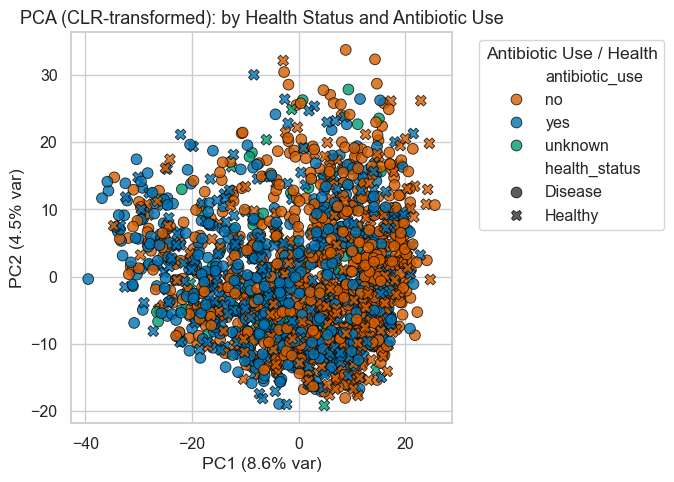

In [45]:
# Plot: PCA (CLR) colored by Antibiotic Use
plt.figure(figsize=(7,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=clr_df, x='PC1', y='PC2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00','yes':'#0072B2','unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): by Health Status and Antibiotic Use", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Antibiotic Use / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pca_clr_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


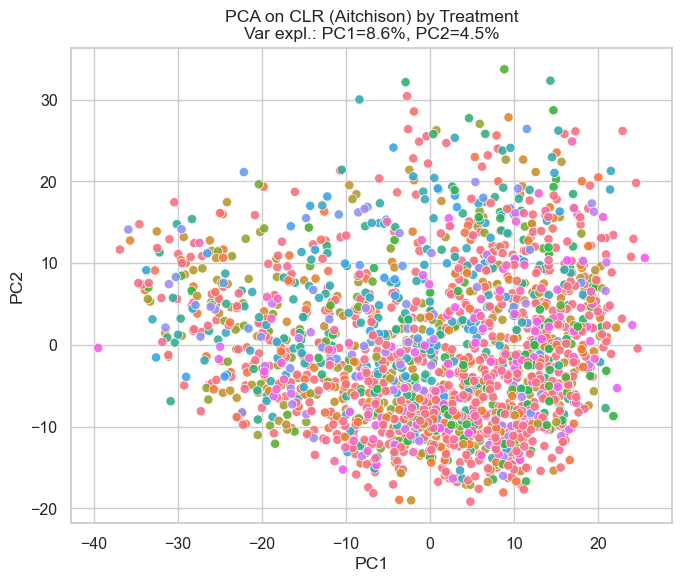

In [46]:
# by Treatment
if meta['treatment'].notna().sum() > 0 and meta['treatment'].nunique() > 1:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=clr_df, x='PC1', y='PC2',
        hue='treatment', s=45, edgecolor='white', alpha=0.9, legend=False
    )
    plt.title(f"PCA on CLR (Aitchison) by Treatment\nVar expl.: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, "pca_clr_by_treatment.png"), dpi=300, bbox_inches='tight')
    plt.show()



# PERMANOVA on Aitchison

In [47]:
# PERMANOVA on Aitchison (Euclidean on CLR space)
    # Euclidean distance in CLR space
clr_dist = pdist(ab_clr.values, metric='euclidean')
clr_DM = squareform(clr_dist)
dm_clr = DistanceMatrix(clr_DM, ids=list(ab_clr.index))
res_health_clr = permanova(dm_clr, clr_df['health_status'], permutations=999)
print("\nPERMANOVA (Aitchison/CLR Euclidean) ~ health_status")
print(res_health_clr)
res_abx_clr = permanova(dm_clr, clr_df['antibiotic_use'], permutations=999)
print("\nPERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use")
print(res_abx_clr)
with open(os.path.join(TABLES, "permanova_aitchison_clr.txt"), "w") as f:
    f.write("PERMANOVA (Aitchison/CLR Euclidean) ~ health_status\n")
    f.write(str(res_health_clr) + "\n\n")
    f.write("PERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use\n")
    f.write(str(res_abx_clr) + "\n")

print("[Info] PERMANOVA on Aitchison skipped (scikit-bio not installed).")


PERMANOVA (Aitchison/CLR Euclidean) ~ health_status
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  2
test statistic              5.50208
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  3
test statistic             5.424421
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
[Info] PERMANOVA on Aitchison skipped (scikit-bio not installed).


# Feature Selection: L1 (Lasso) vs L2 (Ridge) Regularization

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.patches as mpatches

# Prepare data for classification
# Target: Health status (Healthy vs Disease)
y = meta.loc[ab_rel.index, 'health_status'].map({'Healthy': 1, 'Disease': 0})
X = ab_rel.values

# Standardize features (important for regularization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features (taxa): {X_scaled.shape[1]}")
print(f"Samples: {X_scaled.shape[0]}")
print(f"Class distribution:\n{y.value_counts()}")


Features (taxa): 362
Samples: 1831
Class distribution:
health_status
0    1189
1     642
Name: count, dtype: int64


## 1) L1 Regularization (Lasso / Elastic Net)

In [50]:
# L1 regularization via LogisticRegression with L1 penalty
# Test multiple C values (inverse of regularization strength)
C_values = np.logspace(-4, 2, 50)
l1_scores = []
l1_n_features = []
l1_model_coefs = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

for C in C_values:
    # Logistic Regression with L1 penalty
    model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=C,
        max_iter=1000,
        random_state=2025
    )

    # Cross-validation score
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc',n_jobs=1)
    l1_scores.append(scores.mean())

    # Fit on full data to count non-zero coefficients
    model.fit(X_scaled, y)
    n_nonzero = np.sum(model.coef_[0] != 0)
    l1_n_features.append(n_nonzero)
    l1_model_coefs[C] = model.coef_[0].copy()

l1_scores = np.array(l1_scores)
l1_n_features = np.array(l1_n_features)

# Find optimal C
best_idx_l1 = np.argmax(l1_scores)
best_C_l1 = C_values[best_idx_l1]
best_score_l1 = l1_scores[best_idx_l1]
best_n_features_l1 = l1_n_features[best_idx_l1]

print(f"L1 (Lasso) Results:")
print(f"  Optimal C: {best_C_l1:.4f}")
print(f"  Best CV score (ROC-AUC): {best_score_l1:.4f}")
print(f"  Number of selected features: {best_n_features_l1} / {X_scaled.shape[1]}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

L1 (Lasso) Results:
  Optimal C: 0.0373
  Best CV score (ROC-AUC): 0.6567
  Number of selected features: 81 / 362


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 2) L2 Regularization (Ridge)

In [53]:
 # L2 regularization via LogisticRegression with L2 penalty
alpha_values = np.logspace(-4, 2, 50)
l2_scores = []
l2_coefs = {}

for alpha in alpha_values:
    # Logistic Regression with L2 penalty (default)
    model = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        C=1/alpha,
        max_iter=1000,
        random_state=2025
    )

    # Cross-validation score
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc',n_jobs=1)
    l2_scores.append(scores.mean())

    # Store coefficients
    model.fit(X_scaled, y)
    l2_coefs[alpha] = model.coef_[0].copy()

l2_scores = np.array(l2_scores)

# Find optimal alpha (C = 1/alpha)
best_idx_l2 = np.argmax(l2_scores)
best_alpha_l2 = alpha_values[best_idx_l2]
best_C_l2 = 1 / best_alpha_l2
best_score_l2 = l2_scores[best_idx_l2]

print(f"\nL2 (Ridge) Results:")
print(f"  Optimal C (1/alpha): {best_C_l2:.4f}")
print(f"  Best CV score (ROC-AUC): {best_score_l2:.4f}")
print(f"  Number of selected features (|coef| > 0.01): {np.sum(np.abs(l2_coefs[best_alpha_l2]) > 0.01)}")



L2 (Ridge) Results:
  Optimal C (1/alpha): 0.0100
  Best CV score (ROC-AUC): 0.6475
  Number of selected features (|coef| > 0.01): 313


## 3) Comparison: L1 vs L2

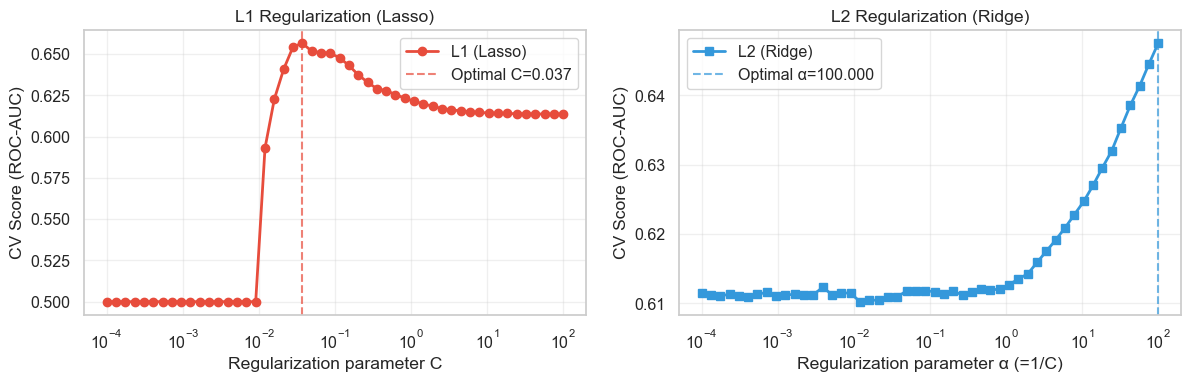

In [54]:
# Plot: CV scores vs regularization strength
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# L1: CV score vs C
ax1 = axes[0]
ax1.semilogx(C_values, l1_scores, marker='o', linewidth=2, label='L1 (Lasso)', color='#E74C3C')
ax1.axvline(best_C_l1, color='#E74C3C', linestyle='--', alpha=0.7, label=f'Optimal C={best_C_l1:.3f}')
ax1.set_xlabel("Regularization parameter C")
ax1.set_ylabel("CV Score (ROC-AUC)")
ax1.set_title("L1 Regularization (Lasso)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# L2: CV score vs alpha
ax2 = axes[1]
ax2.semilogx(alpha_values, l2_scores, marker='s', linewidth=2, label='L2 (Ridge)', color='#3498DB')
ax2.axvline(best_alpha_l2, color='#3498DB', linestyle='--', alpha=0.7, label=f'Optimal α={best_alpha_l2:.3f}')
ax2.set_xlabel("Regularization parameter α (=1/C)")
ax2.set_ylabel("CV Score (ROC-AUC)")
ax2.set_title("L2 Regularization (Ridge)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGS, "regularization_cv_scores.png"), dpi=300, bbox_inches='tight')
plt.show()


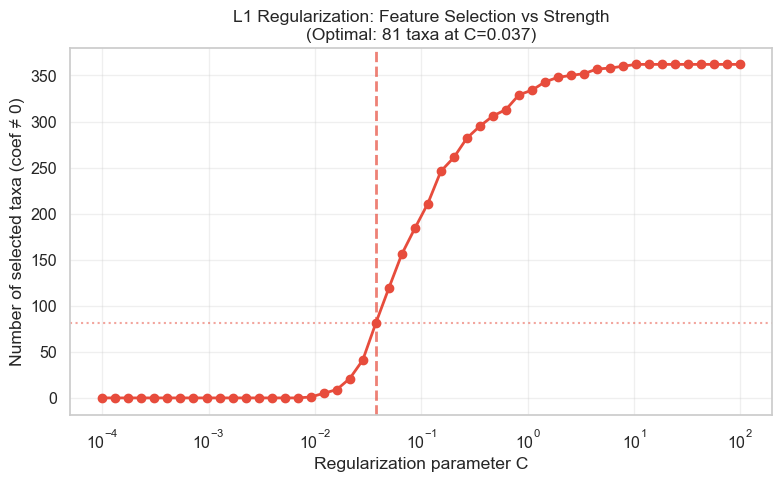

In [55]:
# Plot: Number of selected features vs regularization (L1)
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogx(C_values, l1_n_features, marker='o', linewidth=2, color='#E74C3C', markersize=6)
ax.axvline(best_C_l1, color='#E74C3C', linestyle='--', alpha=0.7, linewidth=2)
ax.axhline(best_n_features_l1, color='#E74C3C', linestyle=':', alpha=0.5)
ax.set_xlabel("Regularization parameter C")
ax.set_ylabel("Number of selected taxa (coef ≠ 0)")
ax.set_title(f"L1 Regularization: Feature Selection vs Strength\n(Optimal: {best_n_features_l1} taxa at C={best_C_l1:.3f})")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "l1_feature_count.png"), dpi=300, bbox_inches='tight')
plt.show()


## 4) Extract selected features (taxa)

In [56]:
# Get L1 selected taxa
l1_coefs = l1_model_coefs[best_C_l1]
l1_selected_idx = np.where(l1_coefs != 0)[0]
l1_selected_taxa = ab_rel.columns[l1_selected_idx]
l1_selected_coefs = l1_coefs[l1_selected_idx]

# Sort by absolute coefficient value
l1_sorted_idx = np.argsort(np.abs(l1_selected_coefs))[::-1]
l1_sorted_taxa = l1_selected_taxa[l1_sorted_idx]
l1_sorted_coefs = l1_selected_coefs[l1_sorted_idx]

print(f"\nL1-Selected Taxa ({len(l1_sorted_taxa)} total):")
l1_results = pd.DataFrame({
    'taxon': l1_sorted_taxa,
    'coefficient': l1_sorted_coefs,
    'abs_coefficient': np.abs(l1_sorted_coefs)
})
l1_results = l1_results.sort_values('abs_coefficient', ascending=False)
print(l1_results.head(15))



L1-Selected Taxa (81 total):
                            taxon  coefficient  abs_coefficient
0                Escherichia coli    -0.263036         0.263036
1     Streptococcus parasanguinis    -0.184321         0.184321
2      Streptococcus thermophilus     0.124776         0.124776
3         Eubacterium sp. CAG:180    -0.114110         0.114110
4         Roseburia inulinivorans    -0.092056         0.092056
5   Limosilactobacillus fermentum    -0.086617         0.086617
6     Firmicutes bacterium CAG:95     0.085243         0.085243
7           Roseburia sp. CAG:309     0.081418         0.081418
8              Bacteroides faecis    -0.074934         0.074934
9       Lachnospira pectinoschiza     0.065624         0.065624
10        Clostridium sp. CAG:167     0.060350         0.060350
11         Oscillibacter sp. PC13     0.058972         0.058972
12        Bacteroides sp. CAG:144     0.057163         0.057163
13   Faecalibacterium prausnitzii     0.055924         0.055924
14        

In [57]:
# Get L2 selected taxa (threshold: |coef| > 0.01)
l2_coefs_best = l2_coefs[best_alpha_l2]
l2_threshold = 0.01
l2_selected_idx = np.where(np.abs(l2_coefs_best) > l2_threshold)[0]
l2_selected_taxa = ab_rel.columns[l2_selected_idx]
l2_selected_coefs = l2_coefs_best[l2_selected_idx]

# Sort by absolute coefficient
l2_sorted_idx = np.argsort(np.abs(l2_selected_coefs))[::-1]
l2_sorted_taxa = l2_selected_taxa[l2_sorted_idx]
l2_sorted_coefs = l2_selected_coefs[l2_sorted_idx]

print(f"\nL2-Selected Taxa (|coef| > {l2_threshold}, {len(l2_sorted_taxa)} total):")
l2_results = pd.DataFrame({
    'taxon': l2_sorted_taxa,
    'coefficient': l2_sorted_coefs,
    'abs_coefficient': np.abs(l2_sorted_coefs)
})
l2_results = l2_results.sort_values('abs_coefficient', ascending=False)
print(l2_results.head(15))



L2-Selected Taxa (|coef| > 0.01, 313 total):
                                taxon  coefficient  abs_coefficient
0                    Escherichia coli    -0.234896         0.234896
1             Roseburia inulinivorans    -0.177226         0.177226
2       Limosilactobacillus fermentum    -0.160798         0.160798
3          Streptococcus thermophilus     0.156370         0.156370
4             Eubacterium sp. CAG:180    -0.153088         0.153088
5                Phocaeicola vulgatus     0.130313         0.130313
6                  Bacteroides faecis    -0.129878         0.129878
7                   Turicimonas muris    -0.125288         0.125288
8                 Enorma massiliensis    -0.122783         0.122783
9                Paraprevotella clara     0.122440         0.122440
10        Firmicutes bacterium CAG:95     0.121681         0.121681
11        Megasphaera micronuciformis     0.120675         0.120675
12              Streptococcus sp. A12    -0.115366         0.115366
13

## 5) Comparison: Which taxa are selected by both?

In [58]:
# Overlap
l1_set = set(l1_sorted_taxa)
l2_set = set(l2_sorted_taxa)
overlap = l1_set.intersection(l2_set)
l1_only = l1_set - l2_set
l2_only = l2_set - l1_set

print(f"\nOverlap Analysis:")
print(f"  L1 only: {len(l1_only)} taxa")
print(f"  L2 only: {len(l2_only)} taxa")
print(f"  Both: {len(overlap)} taxa")

if len(overlap) > 0:
    print(f"\nTaxa selected by BOTH methods (high confidence):")
    overlap_l1 = l1_results[l1_results['taxon'].isin(overlap)].sort_values('abs_coefficient', ascending=False)
    overlap_l2 = l2_results[l2_results['taxon'].isin(overlap)].sort_values('abs_coefficient', ascending=False)
    print(overlap_l1.head(10))



Overlap Analysis:
  L1 only: 1 taxa
  L2 only: 233 taxa
  Both: 80 taxa

Taxa selected by BOTH methods (high confidence):
                           taxon  coefficient  abs_coefficient
0               Escherichia coli    -0.263036         0.263036
1    Streptococcus parasanguinis    -0.184321         0.184321
2     Streptococcus thermophilus     0.124776         0.124776
3        Eubacterium sp. CAG:180    -0.114110         0.114110
4        Roseburia inulinivorans    -0.092056         0.092056
5  Limosilactobacillus fermentum    -0.086617         0.086617
6    Firmicutes bacterium CAG:95     0.085243         0.085243
7          Roseburia sp. CAG:309     0.081418         0.081418
8             Bacteroides faecis    -0.074934         0.074934
9      Lachnospira pectinoschiza     0.065624         0.065624


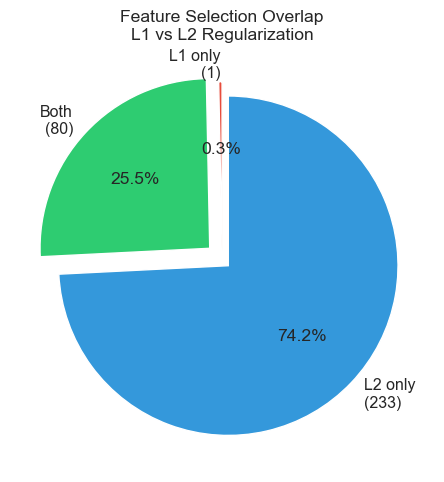

In [59]:
# Venn diagram-style summary
fig, ax = plt.subplots(figsize=(6, 5))
labels = [f'L1 only\n({len(l1_only)})', f'Both\n({len(overlap)})', f'L2 only\n({len(l2_only)})']
sizes = [len(l1_only), len(overlap), len(l2_only)]
colors = ['#E74C3C', '#2ECC71', '#3498DB']
explode = (0.05, 0.1, 0.05)

ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=explode, startangle=90)
ax.set_title(f"Feature Selection Overlap\nL1 vs L2 Regularization")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "feature_selection_overlap.png"), dpi=300, bbox_inches='tight')
plt.show()


## 6) Coefficient comparison plot

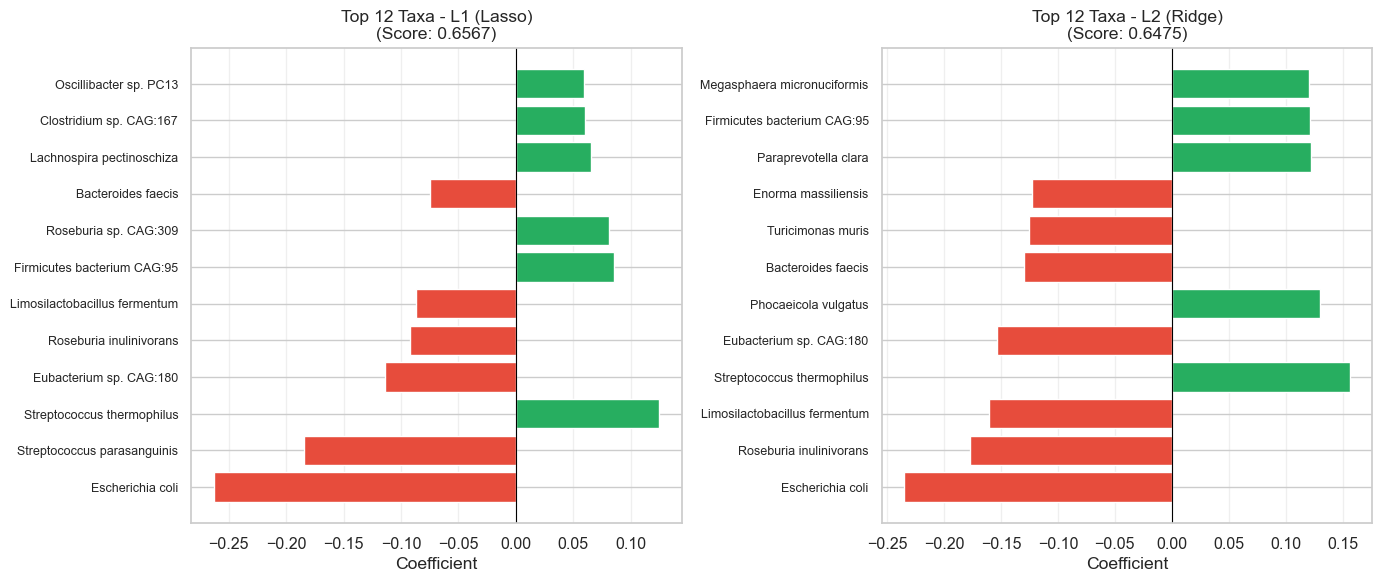

In [62]:
# Plot: Top taxa coefficients (L1 vs L2)
top_n = 12
top_l1 = l1_results.head(top_n)
top_l2 = l2_results.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# L1 coefficients
ax1 = axes[0]
colors_l1 = ['#27AE60' if c > 0 else '#E74C3C' for c in top_l1['coefficient'].values]
ax1.barh(range(len(top_l1)), top_l1['coefficient'].values, color=colors_l1)
ax1.set_yticks(range(len(top_l1)))
ax1.set_yticklabels([t[:30] for t in top_l1['taxon'].values], fontsize=9)
ax1.set_xlabel("Coefficient")
ax1.set_title(f"Top {top_n} Taxa - L1 (Lasso)\n(Score: {best_score_l1:.4f})")
ax1.axvline(0, color='black', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# L2 coefficients
ax2 = axes[1]
colors_l2 = ['#27AE60' if c > 0 else '#E74C3C' for c in top_l2['coefficient'].values]
ax2.barh(range(len(top_l2)), top_l2['coefficient'].values, color=colors_l2)
ax2.set_yticks(range(len(top_l2)))
ax2.set_yticklabels([t[:30] for t in top_l2['taxon'].values], fontsize=9)
ax2.set_xlabel("Coefficient")
ax2.set_title(f"Top {top_n} Taxa - L2 (Ridge)\n(Score: {best_score_l2:.4f})")
ax2.axvline(0, color='black', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(FIGS, "top_taxa_coefficients_l1_vs_l2.png"), dpi=300, bbox_inches='tight')
plt.show()


## 7) Summary table & export

In [61]:
# Create comprehensive summary
summary = pd.DataFrame({
    'Method': ['L1 (Lasso)', 'L2 (Ridge)'],
    'Optimal_Parameter': [f'C={best_C_l1:.4f}', f'α={best_alpha_l2:.4f}'],
    'CV_Score_ROC_AUC': [best_score_l1, best_score_l2],
    'Num_Selected_Features': [len(l1_sorted_taxa), len(l2_sorted_taxa)],
    'Sparsity': [f'{(1 - len(l1_sorted_taxa)/X_scaled.shape[1])*100:.1f}%',
                 f'{(1 - len(l2_sorted_taxa)/X_scaled.shape[1])*100:.1f}%']
})

print("\n" + "="*80)
print("FEATURE SELECTION SUMMARY: L1 vs L2 REGULARIZATION")
print("="*80)
print(summary.to_string(index=False))
print("="*80)

# Export results
l1_results.to_csv(os.path.join(TABLES, "feature_selection_l1_lasso.csv"), index=False)
l2_results.to_csv(os.path.join(TABLES, "feature_selection_l2_ridge.csv"), index=False)
summary.to_csv(os.path.join(TABLES, "feature_selection_summary.csv"), index=False)

print(f"\nResults saved to {TABLES}/")


FEATURE SELECTION SUMMARY: L1 vs L2 REGULARIZATION
    Method Optimal_Parameter  CV_Score_ROC_AUC  Num_Selected_Features Sparsity
L1 (Lasso)          C=0.0373          0.656708                     81    77.6%
L2 (Ridge)        α=100.0000          0.647527                    313    13.5%

Results saved to data/results_EDA/tables/
